# Base Notebook

## 0. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

import re
#from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer

#from datasets import load_dataset

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 나눔 폰트 경로를 직접 설정 
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()

In [3]:
from konlpy.tag import Kkma
kkma = Kkma()

In [4]:
# max_len 도출
from typing import List

def calculate_optimal_max_len(lengths: List[int], thresholds=[128, 256, 512], percentile=90) -> int:
    """
    Calculates the optimal max_len based on the specified percentile of the lengths.
    
    Args:
        lengths (List[int]): List of lengths of each text sample.
        thresholds (List[int]): Possible threshold values to choose from.
        percentile (int): The percentile to use as the cutoff for length.

    Returns:
        int: The optimal max_len based on the given percentile.
    """
    # Calculate the length at the specified percentile
    max_len_suggestion = np.percentile(lengths, percentile)
    
    # Find the closest threshold
    optimal_max_len = min(thresholds, key=lambda x: abs(x - max_len_suggestion))
    
    # Plot length distribution and percentile line
    plt.hist(lengths, bins=30, alpha=0.6, color='b', edgecolor='black')
    plt.axvline(max_len_suggestion, color='red', linestyle='--', label=f'{percentile}th percentile = {int(max_len_suggestion)}')
    plt.axvline(optimal_max_len, color='green', linestyle='-', label=f'Chosen max_len = {optimal_max_len}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution with Optimal max_len')
    plt.legend()
    plt.show()
    
    return optimal_max_len

## 1. Load Data

In [5]:
from datasets import load_dataset
data_cn = load_dataset("lbox/lbox_open", "casename_classification", download_mode="force_redownload")
data_cn

Dataset lbox_open downloaded and prepared to /home/keti/.cache/huggingface/datasets/lbox___lbox_open/casename_classification/0.2.0/3d5761e2d9292b674a2adabbe7f4bc200d1985908e6f657e7953c9bf247da7ae. Subsequent calls will reuse this data.


100%|██████████| 4/4 [00:00<00:00, 2204.05it/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1000
    })
    test2: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1294
    })
})

In [6]:
# train + test 추출
train_data = data_cn['train']
test_data = data_cn['test']

train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)

train = train[['casetype', 'casename', 'facts']]
test = test[['casetype', 'casename', 'facts']]

In [7]:
train

,casetype,casename,facts
0,criminal,감염병의예방및관리에관한법률위반,피고인은 고양시 일산서구 B건물 C동에서 ‘D'을 실질적으로 운영하는 자이다.\n보...
1,criminal,감염병의예방및관리에관한법률위반,피고인은 성남시 중원구 B에서 ‘C'이라는 상호의 당구장을 운영하는 사람이다.\n중...
2,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병을 예방하기 위하여나 감염병..."
3,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시ㆍ도지사 또는 시장ㆍ군수ㆍ구청장은 감염병이 유행하면 감염병의 전파를..."
4,criminal,감염병의예방및관리에관한법률위반,"보건복지부장관, 시·도지사 또는 시장·군수·구청장은 감염병의 전파 방지 및 예방을 ..."
...,...,...,...
7995,criminal,횡령,범죄전력\n피고인은 2019. 12. 19. 서울중앙지방법원에서 도로교통법위반(음주...
7996,criminal,횡령,"기초사실\n피고인 B은 2018. 7.경 피고인 A에게 ‘신용도 문제가 있으니, 외..."
7997,criminal,횡령,범죄전력\n피고인 A은 2018. 4. 20. 대구지방법원 안동지원에서 사기죄 등으...
7998,criminal,횡령,피고인은 건설현장에서 목수로 일하는 사람으로 2012.경 지인의 소개로 피해자 B을...


In [8]:
test

,casetype,casename,facts
0,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병이 유행하면 감염병의 전파를..."
1,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시․도지사 또는 시장․군수․구청장은 감염병을 예방하기 위하여 감염병의..."
2,criminal,감염병의예방및관리에관한법률위반,보건복지부장관은 2020. 1. 8.경 코로나바이러스감염증-19(이하 ‘코로나-19...
3,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병을 예방하기 위하여 흥행, ..."
4,criminal,감염병의예방및관리에관한법률위반,"피고인들은 수원시 영통구 C, D호에서 E 유흥주점을 공동으로 운영하는 사람들이다...."
...,...,...,...
995,criminal,횡령,피고인은 2019. 5.경 청주시 흥덕구 B에 있는 피해자 C이 운영하는 'D' 주...
996,criminal,횡령,"피고인은 2019. 1. 12.경 전남 목포시 B, 2층 C직업소개소에서 2019...."
997,criminal,횡령,피고인은 2018. 4. 24.경부터 2018. 7. 9.까지 당진시 B에 있는 C...
998,criminal,횡령,범죄전력\n피고인은 2019. 9. 6. 수원지방법원 평택지원에서 횡령죄로 징역 8...


In [9]:
print(train.shape, test.shape)
print()
print(train.info(), test.info())
print()
print(train.describe(), test.describe())

(8000, 3) (1000, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   casetype  8000 non-null   object
 1   casename  8000 non-null   object
 2   facts     8000 non-null   object
dtypes: object(3)
memory usage: 187.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   casetype  1000 non-null   object
 1   casename  1000 non-null   object
 2   facts     1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB
None None

        casetype          casename  \
count       8000              8000   
unique         2               100   
top     criminal  감염병의예방및관리에관한법률위반   
freq        5440                80   

                                                    facts  
count                                      

## 2. EDA

### Dist

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.8, wspace=0.5, hspace=0.5)

# Train 데이터 casetype 분포
sns.countplot(y="casetype", data=train, order=train['casetype'].value_counts().index, ax=axes[0, 0])
axes[0, 0].set_xlabel('count', fontsize=8)
axes[0, 0].set_ylabel('casetype', fontsize=8)
axes[0, 0].set_title('Distribution of casetype (Train)')

# Train 데이터 casename 분포
sns.countplot(y="casename", data=train, order=train['casename'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_xlabel('count', fontsize=8)
axes[0, 1].set_ylabel('casename', fontsize=8)
axes[0, 1].set_title('Distribution of casename (Train)')

# test 데이터 casetype 분포
sns.countplot(y="casetype", data=test, order=test['casetype'].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_xlabel('count', fontsize=8)
axes[1, 0].set_ylabel('casetype', fontsize=8)
axes[1, 0].set_title('Distribution of casetype (test)')

# test 데이터 casename 분포
sns.countplot(y="casename", data=test, order=test['casename'].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_xlabel('count', fontsize=8)
axes[1, 1].set_ylabel('casename', fontsize=8)
axes[1, 1].set_title('Distribution of casename (test)')

plt.xticks(rotation=90)  # x축 글자 90도 회전
plt.show()


### len

In [ ]:
# train과 test 데이터셋의 'doc_len' 칼럼 생성
train['doc_len'] = train.facts.apply(lambda words: len(words.split()))
test['doc_len'] = test.facts.apply(lambda words: len(words.split()))

# plot
plt.figure(figsize=(10, 6))
sns.kdeplot(train['doc_len'], label='Train Document lengths', shade=True, color="blue")
sns.kdeplot(test['doc_len'], label='test Document lengths', shade=True, color="orange")
plt.axvline(x=train['doc_len'].mean(), color='blue', linestyle='--', label=f'Train mean: {train["doc_len"].mean():.0f}')
plt.axvline(x=test['doc_len'].mean(), color='orange', linestyle='--', label=f'test mean: {test["doc_len"].mean():.0f}')
plt.title("Document Lengths Distribution")
plt.xlabel("Document Length")
plt.ylabel("Density")
plt.legend()
plt.show()

# 가장 긴 문장과 가장 짧은 문장의 단어 수 출력
max_train_len = train['doc_len'].max()
min_train_len = train['doc_len'].min()
max_test_len = test['doc_len'].max()
min_test_len = test['doc_len'].min()

print(f"Train 데이터셋에서 가장 긴 문장: {max_train_len}개의 단어")
print(f"Train 데이터셋에서 가장 짧은 문장: {min_train_len}개의 단어")
print(f"test 데이터셋에서 가장 긴 문장: {max_test_len}개의 단어")
print(f"test 데이터셋에서 가장 짧은 문장: {min_test_len}개의 단어")

### Base WordCloud
토크나이저와 불용어 전처리를 모두 적용하지 않음

In [ ]:
def base_wordcloud(data, text_column_name):
    # 모든 텍스트를 하나의 문자열로 결합
    text = " ".join(data[text_column_name].dropna().tolist())
    
    # 워드 클라우드 생성
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로
        width=800, 
        height=400, 
        background_color='white'
    ).generate(text)
    
    # 워드 클라우드 표시
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
print('train')
print (base_wordcloud(train, 'facts'))

print('test')
print( base_wordcloud(test, 'facts'))

## 3. Embedding

- 데이터 전처리
- 형태소 분석기 적용

### BASE

In [ ]:
# 전처리 함수 정의
def preprocess(text):
    # 1. 특수 문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    
    # 2. 소문자 변환 (영어가 포함된 경우에 유효)
    text = text.lower()
    
    # 3. 토큰화
    tokens = text.split()
    
    # 4. Kkma를 사용한 형태소 분석
    words = kkma.morphs(' '.join(tokens))  # 형태소 단위로 분리
    
    # 5. 최종 문서 형태로 반환
    return ' '.join(words)

In [ ]:
train['facts_pre'] = train['facts'].apply(preprocess)
test['facts_pre'] = test['facts'].apply(preprocess)

In [ ]:
train

In [ ]:
test

In [34]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

def visualize_similarity_distance(vector1, vector2):
    # 코사인 유사도 및 유클리디안 거리 계산
    similarity_block = cosine_similarity(vector1, vector2)
    euc_distances = euclidean_distances(vector1, vector2)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    
    # 코사인 유사도 히트맵
    plt.subplot(1, 2, 1)
    sns.heatmap(similarity_block, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Cosine Similarity")
    plt.xlabel("train")
    plt.ylabel("test")
    
    # 유클리디안 거리 히트맵
    plt.subplot(1, 2, 2)
    sns.heatmap(euc_distances, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Euclidean Distance")
    plt.xlabel("train")
    plt.ylabel("test")
    
    plt.show()

### 3.1. TF-IDF 
Term Frequency - Inverse Documents Frequency


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(train['facts_pre'])
test_tfidf = vectorizer.transform(test['facts_pre'])

visualize_similarity_distance(train_tfidf, test_tfidf)

### 3.2. Word2Vec


In [ ]:
# 문장 벡터 평균 계산 함수
def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

In [ ]:
from gensim.models import Word2Vec

# Word2Vec 모델 학습
sentences = [comment.split() for comment in train['facts_pre']] + [sentence.split() for sentence in test['facts_pre']]
model = Word2Vec(sentences,
                 vector_size=100,
                 window=5,
                 min_count=1,
                 workers=4
                 )

# 각 데이터셋의 문장 벡터 생성
train_word2vec = np.array([sentence_vector(comment, model) for comment in train['facts_pre']])
test_word2vec = np.array([sentence_vector(sentence, model) for sentence in test['facts_pre']])
visualize_similarity_distance(train_word2vec, test_word2vec)

### 3.3. KoBERT
Pretrained LM

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
from transformers import BertTokenizer, BertModel

kobert_model = BertModel.from_pretrained("monologg/kobert").to(device)
kobert_tokenizer = BertTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [37]:
# 임베딩 함수 정의 (GPU 사용)
def get_embedding(text, pbar=None):
    inputs = kobert_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = kobert_model(**inputs)
    # [CLS] 토큰의 임베딩을 사용
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    
    return embedding


# train과 test 데이터셋의 facts 컬럼 임베딩 생성 후 배열로 변환
train_embeddings = np.array([get_embedding(text) for text in train["facts"]])
test_embeddings = np.array([get_embedding(text) for text in test["facts"]])

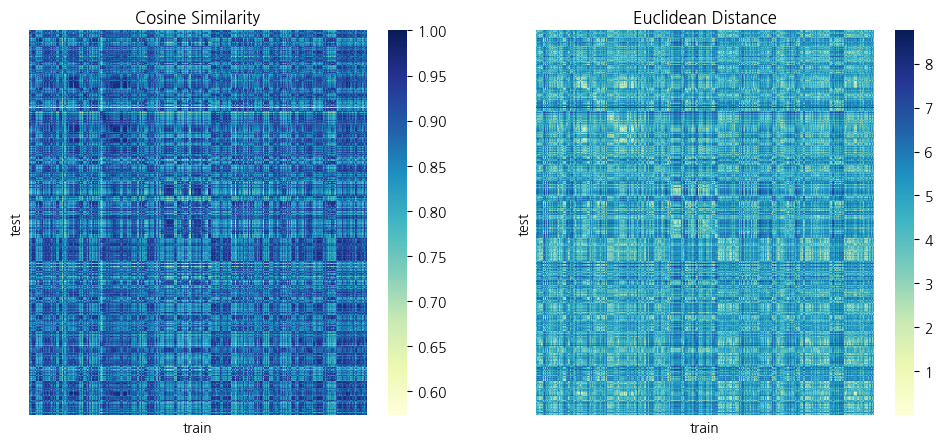

In [38]:
visualize_similarity_distance(train_embeddings, test_embeddings)

Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


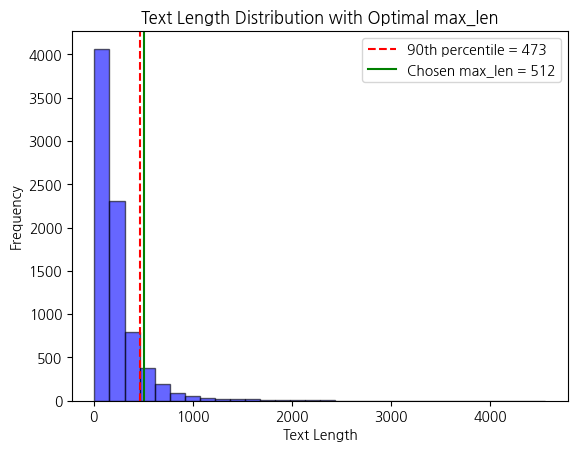

In [14]:
token_lengths = [len(kobert_tokenizer.encode(text)) for text in train.facts]

max_len = calculate_optimal_max_len(token_lengths)

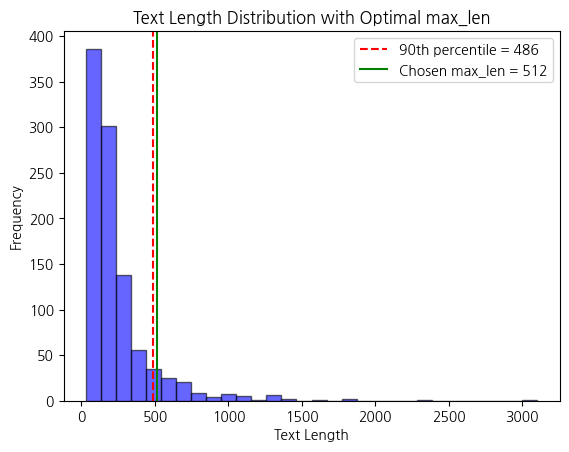

512

In [15]:
token_lengths = [len(kobert_tokenizer.encode(text)) for text in test.facts]

calculate_optimal_max_len(token_lengths)

#### LSDD Drift 
> Least-Squares Density Difference 두 분포 간의 밀도 차이를 직접 최소 제곱법으로 추정

In [12]:
from torch.utils.data import Dataset

# 텍스트 데이터를 위한 Dataset 정의
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

In [16]:
from alibi_detect.cd import LSDDDrift
import time
from tqdm import tqdm  
from torch.utils.data import DataLoader

# DriftDetection 클래스

class DriftDetection:
    def __init__(self, tokenizer, model, device, batch_size=8, p_val=0.05, max_length=max_len):
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        self.batch_size = batch_size
        self.max_length = max_length
        self.p_val = p_val
        self.cd = None

    def encode_texts(self, texts):
        encodings = self.tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=self.max_length)
        encodings = {key: val.to(self.device) for key, val in encodings.items()}
        with torch.no_grad():
            outputs = self.model(**encodings)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings

    def fit(self, train_data):
        """train 데이터를 이용해 드리프트 감지기 초기화"""
        dataset = TextDataset(train_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        all_embeddings = []

        start_time = time.time()
        for batch_texts in tqdm(dataloader, desc="Fitting model", unit="batch"):
            embeddings = self.encode_texts(batch_texts).cpu()
            all_embeddings.append(embeddings)

        # 모든 배치의 임베딩을 합쳐서 LSDDDrift 초기화에 사용
        all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
        self.cd = LSDDDrift(x_ref=all_embeddings, p_val=self.p_val, backend='pytorch')

        end_time = time.time()
        print(f"Fitting completed in {end_time - start_time:.2f} seconds")

    def predict(self, test_data):
        """test 데이터를 이용해 드리프트 감지 예측 수행"""
        dataset = TextDataset(test_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        drift_results = []

        start_time = time.time()
        for batch_texts in tqdm(dataloader, desc="Predicting drift", unit="batch"):
            embeddings = self.encode_texts(batch_texts).cpu().numpy()
            predictions = self.cd.predict(embeddings)

            # predictions['data']['is_drift']가 리스트인지 정수인지 확인 후 추가
            is_drift = predictions['data']['is_drift']
            if isinstance(is_drift, list):
                drift_results.extend(is_drift)
            else:
                drift_results.append(is_drift)

        end_time = time.time()
        print(f"Prediction completed in {end_time - start_time:.2f} seconds")

        return drift_results

In [17]:
# DriftDetection 객체 생성 및 데이터 처리
drift_detector = DriftDetection(kobert_tokenizer, kobert_model, device, batch_size=8, p_val=0.05, max_length=max_len)

# 1. 학습 데이터에 대해 모델 초기화 (fit)
train_facts = list(train["facts"])  # 텍스트 데이터 준비
drift_detector.fit(train_facts)

Fitting model: 100%|██████████| 1000/1000 [00:29<00:00, 33.72batch/s]


Fitting completed in 29.89 seconds


In [18]:
test_facts = list(test["facts"])  # 테스트 텍스트 데이터 준비
drift_results = drift_detector.predict(test_facts)

# 결과 출력
for idx, result in enumerate(drift_results):
    print(f"Test sample {idx} Drift Prediction: {result}") # 배치 크기에 따라 길이 지정

Predicting drift: 100%|██████████| 125/125 [00:06<00:00, 20.75batch/s]

Prediction completed in 6.03 seconds
Test sample 0 Drift Prediction: 1
Test sample 1 Drift Prediction: 1
Test sample 2 Drift Prediction: 1
Test sample 3 Drift Prediction: 1
Test sample 4 Drift Prediction: 1
Test sample 5 Drift Prediction: 1
Test sample 6 Drift Prediction: 1
Test sample 7 Drift Prediction: 1
Test sample 8 Drift Prediction: 1
Test sample 9 Drift Prediction: 1
Test sample 10 Drift Prediction: 1
Test sample 11 Drift Prediction: 0
Test sample 12 Drift Prediction: 1
Test sample 13 Drift Prediction: 1
Test sample 14 Drift Prediction: 0
Test sample 15 Drift Prediction: 1
Test sample 16 Drift Prediction: 1
Test sample 17 Drift Prediction: 1
Test sample 18 Drift Prediction: 1
Test sample 19 Drift Prediction: 1
Test sample 20 Drift Prediction: 1
Test sample 21 Drift Prediction: 1
Test sample 22 Drift Prediction: 1
Test sample 23 Drift Prediction: 1
Test sample 24 Drift Prediction: 1
Test sample 25 Drift Prediction: 1
Test sample 26 Drift Prediction: 1
Test sample 27 Drift Predict

In [81]:
from collections import Counter

print(len(drift_results))
print()
print(Counter(drift_results)) # 1이 감지된 것
print()
print("data drift % : ",  Counter(drift_results)[1]/len(drift_results))

125

Counter({1: 103, 0: 22})

data drift % :  0.824


#### MMD
> Maximum Mean Discrepancy
     두 분포의 평균 차이를 최대화하는 방식으로 분포 간의 차이를 측정

In [82]:
from alibi_detect.cd import MMDDrift
import time
from tqdm import tqdm  
from torch.utils.data import DataLoader
import torch

class DriftDetection:
    def __init__(self, tokenizer, model, device, batch_size=8, p_val=0.05, max_length=max_len):
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        self.batch_size = batch_size
        self.max_length = max_length
        self.p_val = p_val
        self.cd = None

    def encode_texts(self, texts):
        encodings = self.tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=self.max_length)
        encodings = {key: val.to(self.device) for key, val in encodings.items()}
        with torch.no_grad():
            outputs = self.model(**encodings)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings

    def fit(self, train_data):
        """train 데이터를 이용해 드리프트 감지기 초기화"""
        dataset = TextDataset(train_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        all_embeddings = []

        start_time = time.time()
        for batch_texts in tqdm(dataloader, desc="Fitting model", unit="batch"):
            embeddings = self.encode_texts(batch_texts).cpu()
            all_embeddings.append(embeddings)

        # 모든 배치의 임베딩을 합쳐서 MMDDrift 초기화에 사용
        all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
        self.cd = MMDDrift(x_ref=all_embeddings, p_val=self.p_val, backend='pytorch')

        end_time = time.time()
        print(f"Fitting completed in {end_time - start_time:.2f} seconds")

    def predict(self, test_data):
        """test 데이터를 이용해 드리프트 감지 예측 수행"""
        dataset = TextDataset(test_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        drift_results = []

        start_time = time.time()
        for batch_texts in tqdm(dataloader, desc="Predicting drift", unit="batch"):
            embeddings = self.encode_texts(batch_texts).cpu().numpy()
            predictions = self.cd.predict(embeddings)

            # predictions['data']['is_drift']가 리스트인지 정수인지 확인 후 추가
            is_drift = predictions['data']['is_drift']
            if isinstance(is_drift, list):
                drift_results.extend(is_drift)
            else:
                drift_results.append(is_drift)

        end_time = time.time()
        print(f"Prediction completed in {end_time - start_time:.2f} seconds")

        return drift_results


In [83]:
# DriftDetection 객체 생성 및 데이터 처리
drift_detector = DriftDetection(kobert_tokenizer, kobert_model, device, batch_size=8, p_val=0.05, max_length=max_len)

# 1. 학습 데이터에 대해 모델 초기화 (fit)
train_facts = list(train["facts"])  # 텍스트 데이터 준비
drift_detector.fit(train_facts)

Fitting model: 100%|██████████| 1000/1000 [00:28<00:00, 34.52batch/s]

Fitting completed in 28.98 seconds


In [84]:
test_facts = list(test["facts"])  # 테스트 텍스트 데이터 준비
drift_results = drift_detector.predict(test_facts)

# 결과 출력
for idx, result in enumerate(drift_results):
    print(f"Test sample {idx} Drift Prediction: {result}") # 배치 크기에 따라 길이 지정

Predicting drift: 100%|██████████| 125/125 [00:25<00:00,  4.90batch/s]

Prediction completed in 25.49 seconds
Test sample 0 Drift Prediction: 1
Test sample 1 Drift Prediction: 1
Test sample 2 Drift Prediction: 1
Test sample 3 Drift Prediction: 1
Test sample 4 Drift Prediction: 1
Test sample 5 Drift Prediction: 1
Test sample 6 Drift Prediction: 1
Test sample 7 Drift Prediction: 1
Test sample 8 Drift Prediction: 1
Test sample 9 Drift Prediction: 1
Test sample 10 Drift Prediction: 1
Test sample 11 Drift Prediction: 0
Test sample 12 Drift Prediction: 1
Test sample 13 Drift Prediction: 1
Test sample 14 Drift Prediction: 0
Test sample 15 Drift Prediction: 1
Test sample 16 Drift Prediction: 1
Test sample 17 Drift Prediction: 1
Test sample 18 Drift Prediction: 1
Test sample 19 Drift Prediction: 1
Test sample 20 Drift Prediction: 1
Test sample 21 Drift Prediction: 1
Test sample 22 Drift Prediction: 1
Test sample 23 Drift Prediction: 1
Test sample 24 Drift Prediction: 1
Test sample 25 Drift Prediction: 0
Test sample 26 Drift Prediction: 1
Test sample 27 Drift Predic

In [85]:
from collections import Counter

print(len(drift_results))
print()
print(Counter(drift_results)) # 1이 감지된 것
print()
print("data drift % : ",  Counter(drift_results)[1]/len(drift_results))

125

Counter({1: 89, 0: 36})

data drift % :  0.712


### 3.4 Korean RoBERTa 

https://huggingface.co/klue/roberta-large

In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
from transformers import AutoModel, AutoTokenizer

roberta_model = AutoModel.from_pretrained("klue/roberta-base").to(device)
roberta_tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")

2024-11-14 10:35:56.249333: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 10:35:56.250460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 10:35:56.271208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 10:35:56.709632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.wei

Token indices sequence length is longer than the specified maximum sequence length for this model (1147 > 512). Running this sequence through the model will result in indexing errors


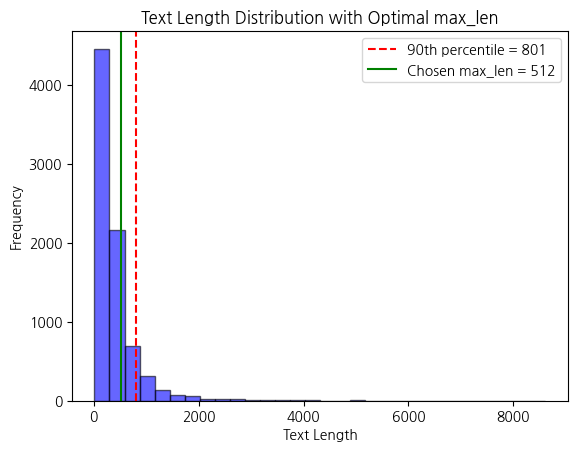

In [12]:
token_lengths = [len(roberta_tokenizer.encode(text)) for text in train["facts"]]

# 최적의 max_len 계산
max_len = calculate_optimal_max_len(token_lengths)

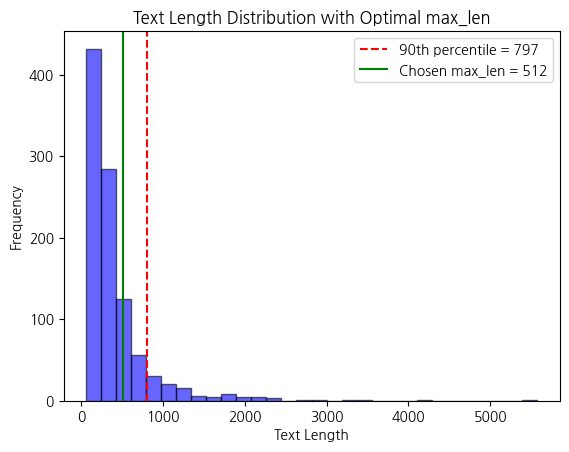

512

In [14]:
token_lengths = [len(roberta_tokenizer.encode(text)) for text in test["facts"]]

calculate_optimal_max_len(token_lengths)

#### LSDD

In [13]:
from torch.utils.data import Dataset

# 텍스트 데이터를 위한 Dataset 정의
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

In [26]:
from alibi_detect.cd import LSDDDrift
import time
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

class DriftDetection:
    def __init__(self, tokenizer, model, device, batch_size=8, p_val=0.05, max_length=128):
        self.tokenizer = tokenizer
        self.model = model.to(device)
        self.device = device
        self.batch_size = batch_size
        self.max_length = max_length
        self.p_val = p_val
        self.cd = None

    def encode_texts(self, texts):
        """텍스트를 KoBERT를 통해 임베딩 벡터로 변환"""
        encodings = self.tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=self.max_length)
        encodings = {key: val.to(self.device) for key, val in encodings.items()}  # 데이터 GPU로 이동
        with torch.no_grad():
            outputs = self.model(**encodings)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings

    def fit(self, train_data):
        """train 데이터를 이용해 드리프트 감지기 초기화"""
        dataset = TextDataset(train_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        all_embeddings = []

        start_time = time.time()
        for batch_texts in tqdm(dataloader, desc="Fitting model", unit="batch"):
            embeddings = self.encode_texts(batch_texts).cpu()  # GPU에서 처리 후 CPU로 이동
            all_embeddings.append(embeddings)

        # 모든 배치의 임베딩을 CPU에 유지하여 LSDDDrift 초기화에 사용
        ## 각 배치의 텍스트 데이터를 임베딩 벡터로 변환
        all_embeddings = torch.cat(all_embeddings, dim=0).numpy()  # 최종적으로 CPU에 있음
        self.cd = LSDDDrift(x_ref=all_embeddings, p_val=self.p_val, backend='pytorch')  # CPU에서 초기화

        end_time = time.time()
        print(f"Fitting completed in {end_time - start_time:.2f} seconds")

    def predict(self, test_data):
        dataset = TextDataset(test_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        all_embeddings = []

        # 각 배치의 임베딩을 하나의 리스트에 모으기
        for batch_texts in tqdm(dataloader, desc="Predicting drift", unit="batch"):
            embeddings = self.encode_texts(batch_texts).cpu()
            all_embeddings.append(embeddings)

            torch.cuda.empty_cache()  # GPU 메모리 확보

        # 모든 배치의 임베딩을 하나의 텐서로 결합
        all_embeddings = torch.cat(all_embeddings, dim=0).numpy()

        # 결합된 전체 임베딩을 사용하여 LSDD 드리프트 탐지 수행
        predictions = self.cd.predict(all_embeddings)
        is_drift = predictions['data']['is_drift']
        p_value = predictions['data']['p_val']

        print(f"Overall Drift Prediction: {'Drift Detected' if is_drift else 'No Drift Detected'}")
        print(f"Overall p-value: {p_value}")

        return is_drift, p_value



In [27]:
# DriftDetection 객체 생성 및 데이터 처리
drift_detector = DriftDetection(roberta_tokenizer, roberta_model, device, batch_size=8, p_val=0.05, max_length=max_len)

# 학습 데이터
train_facts = list(train["facts"])  # 텍스트 데이터 준비
drift_detector.fit(train_facts)

Fitting model: 100%|██████████| 1000/1000 [00:29<00:00, 33.78batch/s]

Fitting completed in 29.64 seconds


In [28]:
test_facts = list(test["facts"])

# 전체 데이터에 대한 드리프트 예측 수행
is_drift, p_value = drift_detector.predict(test_facts)


Predicting drift: 100%|██████████| 125/125 [00:04<00:00, 29.08batch/s]


Overall Drift Prediction: No Drift Detected
Overall p-value: 0.20999999344348907


#### MMD

In [29]:
from alibi_detect.cd import MMDDrift
import time
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

class DriftDetection:
    def __init__(self, tokenizer, model, device, batch_size=8, p_val=0.05, max_length=128):
        self.tokenizer = tokenizer
        self.model = model.to(device)
        self.device = device
        self.batch_size = batch_size
        self.max_length = max_length
        self.p_val = p_val
        self.cd = None

    def encode_texts(self, texts):
        """텍스트를 KoBERT를 통해 임베딩 벡터로 변환"""
        encodings = self.tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=self.max_length)
        encodings = {key: val.to(self.device) for key, val in encodings.items()}  # 데이터 GPU로 이동
        with torch.no_grad():
            outputs = self.model(**encodings)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings

    def fit(self, train_data):
        """train 데이터를 이용해 드리프트 감지기 초기화"""
        dataset = TextDataset(train_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        all_embeddings = []

        start_time = time.time()
        for batch_texts in tqdm(dataloader, desc="Fitting model", unit="batch"):
            embeddings = self.encode_texts(batch_texts).cpu()  # GPU에서 처리 후 CPU로 이동
            all_embeddings.append(embeddings)

        # 모든 배치의 임베딩을 CPU에 유지하여 MMDDrift 초기화에 사용
        ## 각 배치의 텍스트 데이터를 임베딩 벡터로 변환
        all_embeddings = torch.cat(all_embeddings, dim=0).numpy()  # 최종적으로 CPU에 있음
        self.cd = MMDDrift(x_ref=all_embeddings, p_val=self.p_val, backend='pytorch')  # CPU에서 초기화

        end_time = time.time()
        print(f"Fitting completed in {end_time - start_time:.2f} seconds")

    def predict(self, test_data):
        dataset = TextDataset(test_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        all_embeddings = []

        # 각 배치의 임베딩을 하나의 리스트에 모으기
        for batch_texts in tqdm(dataloader, desc="Predicting drift", unit="batch"):
            embeddings = self.encode_texts(batch_texts).cpu()
            all_embeddings.append(embeddings)

            torch.cuda.empty_cache()  # GPU 메모리 확보

        # 모든 배치의 임베딩을 하나의 텐서로 결합
        all_embeddings = torch.cat(all_embeddings, dim=0).numpy()

        # 결합된 전체 임베딩을 사용하여 LSDD 드리프트 탐지 수행
        predictions = self.cd.predict(all_embeddings)
        is_drift = predictions['data']['is_drift']
        p_value = predictions['data']['p_val']

        print(f"Overall Drift Prediction: {'Drift Detected' if is_drift else 'No Drift Detected'}")
        print(f"Overall p-value: {p_value}")

        return is_drift, p_value


In [30]:
# DriftDetection 객체 생성 및 데이터 처리
drift_detector = DriftDetection(roberta_tokenizer, roberta_model, device, batch_size=8, p_val=0.05, max_length=max_len)

# 학습 데이터
train_facts = list(train["facts"])  # 텍스트 데이터 준비
drift_detector.fit(train_facts)

Fitting model:   0%|          | 0/1000 [00:00<?, ?batch/s]

Fitting model: 100%|██████████| 1000/1000 [00:29<00:00, 33.62batch/s]

Fitting completed in 29.77 seconds


In [31]:
test_facts = list(test["facts"])

# 전체 데이터에 대한 드리프트 예측 수행
is_drift, p_value = drift_detector.predict(test_facts)

Predicting drift: 100%|██████████| 125/125 [00:04<00:00, 29.54batch/s]


Overall Drift Prediction: No Drift Detected
Overall p-value: 0.20000000298023224
